# Basel_8

In [66]:
%run runaway_functionsv3
%matplotlib qt
cl = Cluster('Basel_8')
cld = ClusterDias('Basel_8')

## CMD

In [37]:
plot_cmd = cl.plot_cmd(isochrones=[Isochrone(cld)])
# show_annotation_manager(plot_pm)

   Name  
---------
HD 259597
   Name  
---------
HD 259787
   Name  
---------
HD 259991


In [38]:
show_annotation_manager(plot_cmd)

## PM

In [39]:
plot_pm = cl.plot_pm()

In [40]:
show_annotation_manager(plot_pm)

## Traceback clean

In [36]:
%run runaway_functionsv3
%matplotlib qt
cl = Cluster('Basel_8')

plot_traceback_clean = cl.plot_traceback_clean()

In [4]:
show_annotation_manager(plot_traceback_clean)


## Traceback PSR

In [69]:
%run runaway_functionsv3
%matplotlib qt
cl = Cluster('Basel_8')
psr_table = cl.psrs()
psr_table
mask = np.isin(psr_table['JNAME'], ["J0641+07"])
psr_table = psr_table[mask]
plot_traceback_psr,wcs = cl.plot_traceback_psr(psr_table=psr_table, trace_time=-115*u.kyr, extra=30)


In [30]:
cl.psrs()

JNAME,RAJD,DECJD,DIST,DIST_DM,AGE,PMRA,PMDEC,S400,ASSOC,AGE_I,PX,P0,P1,BSURF,SkyCoord,sep2d,sep3d
,deg,deg,kpc,kpc,yr,mas / yr,mas / yr,mJy,,yr,mas,s,,G,"deg,deg,kpc",deg,kpc
str12,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,SkyCoord,float64,float64
J0633+0632,98.43420833333332,6.543027777777778,1.355,--,59201.54196602287,--,--,--,GRS,--,--,0.2973951905763917,7.959154948922749e-14,4923233438026.881,"98.43420833333332,6.543027777777778,1.355",1.5001221289676925,0.10184184196052948
J0641+07,100.29166666666667,7.733333333333333,1.257,1.257,--,--,--,--,--,--,--,--,--,--,"100.29166666666667,7.733333333333333,1.257",1.743908226577804,0.19732558371928377
J0625+10,96.4375,10.266666666666667,1.637,1.637,--,--,--,--,--,--,--,0.498397,--,--,"96.4375,10.266666666666667,1.637",3.0576926937161186,0.20427331840708984
J0631+1036,97.86468333333332,10.617361111111112,2.104,2.104,44395.34592893789,--,--,1.5,GRS,--,--,0.28781555571653766,1.0271712510572369e-13,5502100736860.678,"97.86468333333332,10.617361111111112,2.104",2.6684887959280545,0.6590389855676634
J0627+0706,96.93404999999998,7.109166666666666,2.289,2.289,252945.1483866456,--,--,6.0,--,--,--,0.4758849377129841,2.9808604339332905e-14,3811288102334.755,"96.93404999999998,7.109166666666666,2.289",1.858734633129263,0.8410789093069662


In [70]:
show_annotation_manager(plot_traceback_psr)


In [54]:
cl.skycoord.to_string("hmsdms")

'06h34m13.968s +08d02m17.16s'

In [55]:
cl.mymembers

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,e_rmRA,e_rmDE,rRV,e_rRV,v_pec,v_pec3d,e_v_pec,e_v_pec3d,Pmemb
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,km / s,km / s,km / s,km / s,km / s,km / s,
float64,float64,float64,float64,float64,int32,str10,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64,float64
98.38429327278,8.33557580226,0.0298,0.0279,20.6218,--,733-1218-1,3326048448124872320,1517.70947000,0.6283,0.0363,-0.760,-1.057,0.035,0.028,1.363,32036.6,3.9984,8.432107,0.337074,8.528219,8.191145,--,--,1442.38904000,1621.94727000,7981856.09929,1.935e+04,5.298e+06,4.473e+04,4.195e+06,3.635e+04,--,--,0.00381,0.009581,0.01014,0.01972,"98.38429327278,8.33557580226,1517.70947",-0.570,1.126,0.260,0.253,--,--,9.081153222849567,--,2.3092690045811937,--,1.0
98.55031962528,7.98752507297,0.0259,0.0256,3.0701,--,733-1512-1,3326023842254469120,1409.47327000,0.6747,0.0338,-0.049,-2.251,0.033,0.026,1.305,11353.8,3.4433,9.743308,0.202579,9.800635,9.598057,19.20,6.03,1354.19275000,1463.96838000,2385742.02510,856.2,1.641e+06,1297,1.148e+06,614.7,--,--,0.002783,0.002919,0.003824,0.006743,"98.55031962528,7.98752507297,1409.47327",0.141,-0.068,0.258,0.251,-0.05,15.58,1.043214060048465,1.04,0.26762581622056764,0.79,1.0
98.54082660573,8.01212878661,0.0194,0.0180,1.8691,--,733-2228-1,3326024117132373632,1445.86487000,0.6384,0.0232,-0.182,-2.405,0.024,0.021,1.032,--,--,11.888272,0.294881,11.986523,11.691642,--,--,1405.83179000,1494.29736000,330855.23367,85.93,2.192e+05,175.4,1.669e+05,94.7,--,--,0.00277,0.002922,0.003829,0.006752,"98.54082660573,8.01212878661,1445.86487",0.008,-0.222,0.249,0.246,--,--,1.5214955538026567,--,0.3740615801533191,--,0.8
98.47991490921,8.04956098629,0.0149,0.0133,4.7019,--,--,3326028175879616256,1452.00476000,0.6440,0.0172,-0.121,-2.316,0.019,0.016,1.081,9561.1,4.0650,13.194690,0.412356,13.343504,12.931148,--,--,1423.29114000,1486.77441000,99327.79055,60.73,6.281e+04,46.62,5.33e+04,36.04,--,--,0.002834,0.002904,0.00385,0.006754,"98.47991490921,8.04956098629,1452.00476",0.069,-0.133,0.244,0.241,--,--,1.029277061512286,--,0.2485523901457674,--,0.8
98.55007006085,7.86501938128,0.0137,0.0141,10.3957,--,--,3325969180208898432,1470.48962000,0.6390,0.0173,-0.089,-2.365,0.017,0.014,1.110,9412.0,4.0243,13.391542,0.548879,13.596915,13.048037,--,--,1434.64990000,1507.35620000,82857.08176,32.24,4.973e+04,34.79,4.786e+04,27.08,--,--,0.002788,0.002892,0.003829,0.006721,"98.55007006085,7.86501938128,1470.48962",0.101,-0.182,0.242,0.239,--,--,1.448777766372426,--,0.3470607243596529,--,0.9
98.47750157250,8.18827800746,0.0134,0.0127,10.2068,--,--,3326041335659347072,1507.59143000,0.6195,0.0153,-0.189,-2.312,0.017,0.014,0.870,9455.0,4.0699,13.434296,0.469467,13.606323,13.136856,--,--,1478.83008000,1540.77148000,79657.81580,32.15,4.93e+04,47.39,4.41e+04,27.86,--,--,0.00279,0.002979,0.003841,0.00682,"98.4775015725,8.18827800746,1507.59143",0.001,-0.129,0.242,0.239,--,--,0.9209493012040895,--,0.21996667659651986,--,0.8
98.24454758674,8.31487809120,0.0295,0.0282,24.9560,--,--,3326235124583953024,1350.09131000,0.7037,0.0356,-0.143,-2.324,0.035,0.029,1.018,6085.7,4.3650,15.458742,1.038140,15.888773,14.850633,--,--,1285.37537000,1427.07764000,12343.82570,5.489,6024,25.96,9097,17.55,--,--,0.002797,0.005447,0.004321,0.009768,"98.24454758674,8.3148780912,1350.09131",0.047,-0.141,0.260,0.254,--,--,0.9496130918997572,--,0.24162557021889947,--,0.8


# RSG_8


In [71]:
%run runaway_functionsv3
%matplotlib qt
cl = Cluster('RSG_8')
cld = ClusterDias('RSG_8')
# print(latex_text(cl))

In [17]:
nearest_cluster("psr J2337+6151	", output=True)

The nearest cluster to the psr J2337+6151	 is: LP_1843 at a separation of 54.22 arcmin


'LP_1843'

In [17]:
cl.runaways()

Name,RA_ICRS_1,DE_ICRS_1,rgeo,Teff,Temp. Est,v_pec,e_v_pec,v_pec3d,e_v_pec3d,HIP,TYC2,Source,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Gmag,BP-RP,BPmag,RPmag,b_rgeo,B_rgeo,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,e_rmRA,rmDE,e_rmDE,logg,RV,e_RV,rRV,e_rRV,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6
,deg,deg,pc,K,K,km / s,km / s,km / s,km / s,,,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,mag,mag,pc,pc,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,log(cm.s**-2),km / s,km / s,km / s,km / s,,,,,,,,
str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,str11,int64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float32,float64,float32,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,str1,str1
HD 240113,343.69144060690,59.27868153304,427.87841800,9597.7,10810.0,29.83444795045316,1.0849219722886463,29.87,12.80,--,3997-1510-1,2013495997114201472,2.3220,0.0141,-8.513,-6.731,0.017,0.015,0.868,9.060699,0.210127,9.125675,8.915548,424.70175200,430.83926400,0.002769,0.002835,0.003787,0.006622,"343.6914406069,59.27868153304,427.878418",-13.790,0.430,-5.121,0.428,3.8182,-10.33,0.93,1.41,5.52,4473702.71851,1118,3.056e+06,1408,2.152e+06,485,--,--


## CMD

In [18]:
plot_cmd = cl.plot_cmd()

   Name  
---------
HD 218440
   Name  
---------
HD 217348
   Name  
---------
HD 240113


In [19]:
show_annotation_manager(plot_cmd)

## PM

In [72]:
plot_pm = cl.plot_pm()


In [73]:
show_annotation_manager(plot_pm)


## Traceback clean

In [6]:
plot_traceback_clean = cl.plot_traceback_clean()

In [ ]:
show_annotation_manager(plot_traceback_clean)


## Traceback PSR

https://articles.adsabs.harvard.edu/pdf/1993A%26A...276..470F says that the pulsar has a known proper motion because he tried to associate it with an SNR. The distance to the psr he used was 2.2 kpc. The velocity then calculated is using 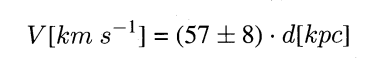 to be 125 km/s. however, another paper https://iopscience.iop.org/article/10.3847/1538-4357/835/1/29/pdf said that the distance is actually 700pc (the cluster distance is 442 pc). then we have the velocity: v=40km/s only. this is velry low according to the Hobbs paper https://articles.adsabs.harvard.edu/pdf/2005MNRAS.360..974H note that the hobbs paper does not include this psr to have a proper motion velocity.


In [25]:
d = 0.7
# d = 2.2
v = 57*d
v

39.9

now  if we associate it with our runaway star, then the required velocity is:


In [29]:
(5*u.rad).to(u.arcmin)

<Quantity 17188.73385392 arcmin>

In [56]:
def rphy(angle, distance):
    angle = angle.to(u.rad)
    distance = distance.to(u.pc)
    rphy = angle*distance
    return rphy

rphy(5.162*u.deg, 400*u.pc)

<Quantity 36.0375584 pc rad>

In [62]:
d = 20*u.pc
t = 40.5*u.kyr

v = (d/t)
v.to(u.km/u.s)

<Quantity 482.86035639 km / s>

In [65]:
450/np.sqrt(3)*np.sqrt(2)

367.42346141747674

In [23]:
cl.psrs(sep_limit=600*u.arcmin)

JNAME,RAJD,DECJD,DIST,DIST_DM,AGE,PMRA,PMDEC,S400,ASSOC,AGE_I,PX,P0,P1,BSURF,SkyCoord,sep2d,sep3d
,deg,deg,kpc,kpc,yr,mas / yr,mas / yr,mJy,,yr,mas,s,,G,"deg,deg,kpc",deg,kpc
str12,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,SkyCoord,float64,float64
J2337+6151,354.2740083333333,61.850425,0.7,2.079,40572.08206929549,-1.0,-15.0,10.0,SNR,40572.1220008336,--,0.4953698680281026,1.9344981915998355e-13,9906013954191.543,"354.2740083333333,61.850425,0.7",5.162921681231478,0.26282041285175817


In [46]:
plot_traceback_psr, wcs = cl.plot_traceback_psr(trace_time=-120*u.kyr)


In [9]:
show_annotation_manager(plot_traceback_psr)


# Berkeley_97

In [4]:
%run runaway_functionsv3
%matplotlib qt
cl = Cluster('Berkeley_97')
cld = ClusterDias("Berkeley_97")


## CMD

In [5]:
plot_cmd = cl.plot_cmd()

   Name  
---------
HD 240016
   Name  
---------
HD 240015


## PM

## Traceback clean

## Traceback PSR

## NGC

In [56]:
%run runaway_functionsv3
%matplotlib qt

cl = Cluster('NGC_4103')
# cl.psrs()

# plot_traceback_clean = cl.plot_traceback_clean()
# show_annotation_manager(plot_traceback_clean)

In [58]:
plot_traceback = cl.plot_traceback_clean()

10pc image downloaded in 15.659262s


In [60]:
show_annotation_manager(plot_traceback)


In [38]:
cl.runaways()

Name,RA_ICRS_1,DE_ICRS_1,rgeo,Teff,Temp. Est,v_pec,e_v_pec,v_pec3d,e_v_pec3d,HIP,TYC2,Source,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Gmag,BP-RP,BPmag,RPmag,b_rgeo,B_rgeo,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,e_rmRA,rmDE,e_rmDE,logg,RV,e_RV,rRV,e_rRV,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6
,deg,deg,pc,K,K,km / s,km / s,km / s,km / s,,,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,mag,mag,pc,pc,,,,,"deg,deg,pc",mas / yr,mas / yr,mas / yr,mas / yr,log(cm.s**-2),km / s,km / s,km / s,km / s,,,,,,,,
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,str11,int64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,SkyCoord,float64,float32,float64,float32,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,str16,str20
NGC 4103 18,181.58811178102,-61.23823562782,1878.34204000,--,15180.0,18.20385229401266,1.7172550944787182,--,--,--,--,6058510799409163904,0.4993,0.0169,-7.963,1.128,0.015,0.018,1.000,13.011804,0.282536,13.111239,12.828704,1817.23865000,1934.55212000,0.002813,0.003552,0.004056,0.007609,"181.58811178102,-61.23823562782,1878.34204",-1.784,0.128,0.999,0.131,--,--,--,--,--,117550.76398,61.49,7.779e+04,157.5,5.857e+04,79.47,--,--


In [46]:
show_annotation_manager(plot_traceback_psr)


In [45]:
%run runaway_functionsv3
%matplotlib qt
# cl = Cluster('Bochum_13')
plot_traceback_psr = cl.plot_traceback_psr(trace_time=-170*u.kyr)
# show_annotation_manager(plot_traceback_psr)
